# Galaxy Generation Tool

1. Adjust the SYSTEMS_COUNT variable (recommended value range is 17-22, for more systems you might have to adjust the scale or min system distance as well).
2. Execute the first cell as many times as you want to obtain desired system layout.
3. Execute the second cell to preview the generated star and planet types for systems.
4. Execute the third cell in order to obtain the preliminary JSON data.
5. Fill out the system and colony planet names, as well as factions, add space stations.
6. Append the resulting sector to `data/game/galaxy/systems.json`.

### Generate points and connections

### Randomize star and planet types

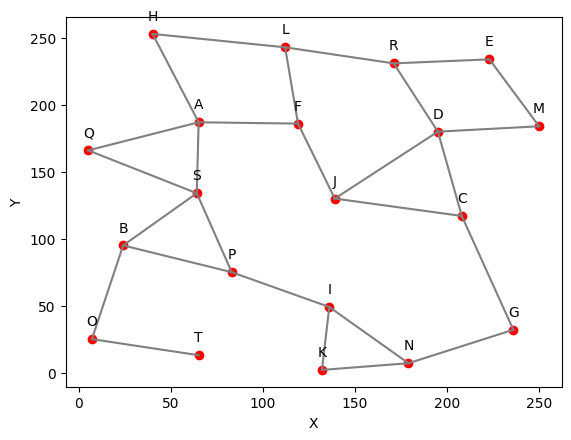

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from string import ascii_uppercase

SYSTEMS_COUNT = 20
SCALE_X = 255
SCALE_Y = 255
MIN_DISTANCE = (SCALE_X + SCALE_Y) / 11


def generate_points(num_points):
    points = []
    point_labels = {}
    label_counter = 0
    while len(points) < num_points:
        point = tuple(
            map(int, np.multiply(np.random.rand(2), np.array((SCALE_X, SCALE_Y))))
        )
        
        if all(
            pdist([point, existing_point]) >= MIN_DISTANCE for existing_point in points
        ):
            points.append(point)
            point_labels[point] = ascii_uppercase[label_counter]
            label_counter += 1
    return points, point_labels


def generate_connections(points):
    connections = []
    dist_matrix = squareform(pdist(points))
    for i in range(len(points)):
        sorted_indices = np.argsort(dist_matrix[i])
        closest_points_indices = [idx for idx in sorted_indices if idx != i]
        num_connections = np.random.choice([1, 2, 3, 4], p=[0.2, 0.5, 0.25, 0.05])
        for index in closest_points_indices[:num_connections]:
            connection = (min(i, index), max(i, index))
            if connection not in connections:
                connections.append(connection)
    return connections


def plot_systems(points, connections):
    np_points = np.array(points)
    plt.scatter(np_points[:, 0], np_points[:, 1], color="red")
    for point in points:
        plt.annotate(
            point_labels[point],
            point,
            textcoords="offset points",
            xytext=(0, 10),
            ha="center",
        )

    for connection in connections:
        point1 = points[connection[0]]
        point2 = points[connection[1]]
        plt.plot([point1[0], point2[0]], [point1[1], point2[1]], color="gray")

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()


points, point_labels = generate_points(SYSTEMS_COUNT)
connections = generate_connections(points)

plot_systems(points, connections)

cell1finished = True
if "cell2finished" in globals():
    del cell2finished

A - id_star_m: ['id_planet_ancient', 'id_planet_tomb', 'id_planet_barren']
B - id_star_m: ['id_planet_barren', 'id_planet_barren', 'id_planet_frozen']
C - id_star_g: ['id_planet_tomb', 'id_planet_tomb', 'id_planet_tomb', 'id_planet_frozen']
D - id_star_g: ['id_planet_tomb', 'id_planet_ancient']
E - id_star_b: ['id_planet_frozen']
F - id_star_g: ['id_planet_gas_giant', 'id_planet_gas_giant', 'id_planet_colony', 'id_planet_ancient']
G - id_star_d: ['id_planet_barren', 'id_planet_unique']
H - id_star_a: ['id_planet_gas_giant', 'id_planet_molten']
I - id_star_g: ['id_planet_tomb', 'id_planet_paradise']
J - id_star_m: ['id_planet_gas_giant', 'id_planet_molten', 'id_planet_tomb']
K - id_star_m: ['id_planet_colony', 'id_planet_ancient', 'id_planet_barren']
L - id_star_g: ['id_planet_gas_giant', 'id_planet_molten']
M - id_star_a: ['id_planet_gas_giant', 'id_planet_molten']
N - id_star_neutron: []
O - id_star_m: ['id_planet_gas_giant', 'id_planet_frozen', 'id_planet_colony']
P - id_star_black_h

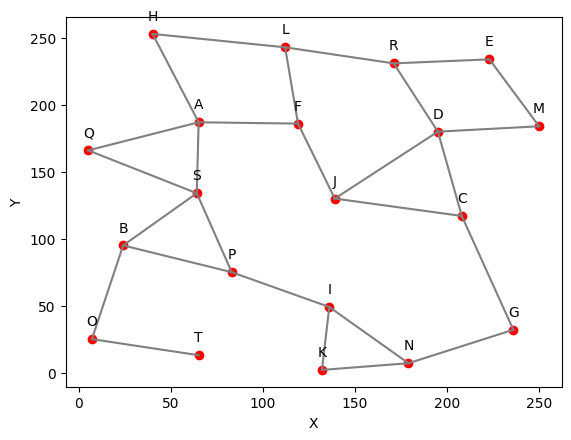

In [74]:
if "cell1finished" not in globals():
    from warnings import filterwarnings

    filterwarnings("ignore", category=UserWarning)
    raise SystemExit("Please run the first cell first.")

import json
from os import path
from pprint import pprint
from math import isclose
import random

data_dir = path.abspath(path.join(__vsc_ipynb_file__, "../../../data"))
planets_data_path = path.join(data_dir, "game/galaxy/planets.json")
stars_data_path = path.join(data_dir, "game/galaxy/stars.json")


def get_json_data(json_file_path, property_name):
    with open(json_file_path, "r") as file:
        json_data = json.load(file)[property_name]
        return json_data


def get_planets_data():
    json_data = get_json_data(planets_data_path, "planetTypes")
    planets = []
    for planet in json_data:
        planets.append(planet)

    return planets


def get_star_planet_range(json_star_data):
    planet_range_str = json_star_data["planetCount"]
    return list(map(int, planet_range_str.split("-")))


def get_stars_planet_data(planets_data):
    json_data = get_json_data(stars_data_path, "starTypes")
    stars = {}
    star_weights = {}
    planet_ranges = {}
    for star in json_data:
        stars[star] = json_data[star]["planetProbabilities"]
        star_weights[star] = json_data[star]["weight"]
        planet_ranges[star] = get_star_planet_range(json_data[star])

        unspec_planets_n = sum(planet not in stars[star] for planet in planets_data)
        total_specified_probability = sum(stars[star].values())

        if not isclose(total_specified_probability, 1):
            unspecified_probability = (
                1 - total_specified_probability
            ) / unspec_planets_n
            for planet in planets_data:
                if planet not in stars[star]:
                    stars[star][planet] = unspecified_probability

    return stars, star_weights, planet_ranges


def generate_stars(points, star_weights):
    systems = []
    for star_coords in points:
        random_star_type = random.choices(
            population=list(star_weights.keys()), weights=list(star_weights.values())
        )[0]
        systems.append((random_star_type, star_coords, [], []))
        # star type, coords, planets, connections, yes I know this should've been a class or something
    return systems


def generate_planets(json_star_data, planet_count):
    while True:
        planets = random.choices(
            population=list(json_star_data.keys()),
            weights=list(json_star_data.values()),
            k=planet_count,
        )
        if planets.count("id_planet_colony") < 2:
            break
    return planets

def fill_connection_data(system_idx, connections_arr):
    for connection in connections:
        if system_idx in connection:
            connections_arr.append( points[ connection[0] if connection[0] != system_idx else connection[1] ] )

def generate_systems_data(stars_data, star_weights, planet_ranges, points, connections):
    systems = generate_stars(points, star_weights)

    for idx, system_data in enumerate( systems ):
        fill_connection_data(idx, system_data[3])
        planet_count = random.randint(*planet_ranges[system_data[0]])
        system_data[2].extend(
            generate_planets(stars_data[system_data[0]], planet_count)
        )
    return systems


planets_data = get_planets_data()
stars_data, star_weights, planet_ranges = get_stars_planet_data(planets_data)

systems_data = generate_systems_data(
    stars_data, star_weights, planet_ranges, points, connections
)

for system in systems_data:
    print(f"{point_labels[system[1]]} - {system[0]}: {system[2]}")
plot_systems(points, connections)

cell2finished = True

### Serialize into JSON 

In [75]:
if "cell2finished" not in globals():
    from warnings import filterwarnings

    filterwarnings("ignore", category=UserWarning)
    raise SystemExit("Please run the second cell first.")


from IPython.display import display, Markdown

OUTPUT_PATH = path.join(path.dirname(__vsc_ipynb_file__), "tool_output.json")


def generate_json_system_data(systems):
    systems_arr = []
    for idx, system in enumerate(systems):
        systems_arr.append(
            {
                "name": point_labels[system[1]],
                "starType": system[0],
                "coordinates": system[1],
                "faction": "id_faction_placeholder",
                "objects": [],
                "connections": system[3],
            }
        )

        for planet in system[2]:
            systems_arr[-1]["objects"].append(
                {
                    "objectType": "type_planet",
                    "planetType": planet,
                    "planetName": "<planet_name>",
                }
            )
            if planet == "id_planet_colony":
                systems_arr[-1]["objects"][-1]["developmentLevel"] = 0

    return '{\n\n"<sector_name>": ' + json.dumps(systems_arr, indent=4) + "\n\n}"


json_sector = generate_json_system_data(systems_data)

with open(OUTPUT_PATH, "w") as f:
    display(
        Markdown(
            "### Results were also saved into [tool_output.json](tool_output.json)"
        )
    )
    display(Markdown("```json\n" + json_sector + "\n```"))
    f.write(json_sector)

### Results were also saved into [tool_output.json](tool_output.json)

```json
{

"<sector_name>": [
    {
        "name": "A",
        "starType": "id_star_m",
        "coordinates": [
            65,
            187
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_ancient",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_tomb",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_barren",
                "planetName": "<planet_name>"
            }
        ],
        "connections": [
            [
                64,
                134
            ],
            [
                119,
                186
            ],
            [
                40,
                253
            ],
            [
                5,
                166
            ]
        ]
    },
    {
        "name": "B",
        "starType": "id_star_m",
        "coordinates": [
            24,
            95
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_barren",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_barren",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_frozen",
                "planetName": "<planet_name>"
            }
        ],
        "connections": [
            [
                64,
                134
            ],
            [
                83,
                75
            ],
            [
                7,
                25
            ]
        ]
    },
    {
        "name": "C",
        "starType": "id_star_g",
        "coordinates": [
            208,
            117
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_tomb",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_tomb",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_tomb",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_frozen",
                "planetName": "<planet_name>"
            }
        ],
        "connections": [
            [
                195,
                180
            ],
            [
                139,
                130
            ],
            [
                236,
                32
            ]
        ]
    },
    {
        "name": "D",
        "starType": "id_star_g",
        "coordinates": [
            195,
            180
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_tomb",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_ancient",
                "planetName": "<planet_name>"
            }
        ],
        "connections": [
            [
                208,
                117
            ],
            [
                250,
                184
            ],
            [
                171,
                231
            ],
            [
                139,
                130
            ]
        ]
    },
    {
        "name": "E",
        "starType": "id_star_b",
        "coordinates": [
            223,
            234
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_frozen",
                "planetName": "<planet_name>"
            }
        ],
        "connections": [
            [
                171,
                231
            ],
            [
                250,
                184
            ]
        ]
    },
    {
        "name": "F",
        "starType": "id_star_g",
        "coordinates": [
            119,
            186
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_gas_giant",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_gas_giant",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_colony",
                "planetName": "<planet_name>",
                "developmentLevel": 0
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_ancient",
                "planetName": "<planet_name>"
            }
        ],
        "connections": [
            [
                65,
                187
            ],
            [
                112,
                243
            ],
            [
                139,
                130
            ]
        ]
    },
    {
        "name": "G",
        "starType": "id_star_d",
        "coordinates": [
            236,
            32
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_barren",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_unique",
                "planetName": "<planet_name>"
            }
        ],
        "connections": [
            [
                179,
                7
            ],
            [
                208,
                117
            ]
        ]
    },
    {
        "name": "H",
        "starType": "id_star_a",
        "coordinates": [
            40,
            253
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_gas_giant",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_molten",
                "planetName": "<planet_name>"
            }
        ],
        "connections": [
            [
                65,
                187
            ],
            [
                112,
                243
            ]
        ]
    },
    {
        "name": "I",
        "starType": "id_star_g",
        "coordinates": [
            136,
            49
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_tomb",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_paradise",
                "planetName": "<planet_name>"
            }
        ],
        "connections": [
            [
                132,
                2
            ],
            [
                83,
                75
            ],
            [
                179,
                7
            ]
        ]
    },
    {
        "name": "J",
        "starType": "id_star_m",
        "coordinates": [
            139,
            130
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_gas_giant",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_molten",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_tomb",
                "planetName": "<planet_name>"
            }
        ],
        "connections": [
            [
                208,
                117
            ],
            [
                119,
                186
            ],
            [
                195,
                180
            ]
        ]
    },
    {
        "name": "K",
        "starType": "id_star_m",
        "coordinates": [
            132,
            2
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_colony",
                "planetName": "<planet_name>",
                "developmentLevel": 0
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_ancient",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_barren",
                "planetName": "<planet_name>"
            }
        ],
        "connections": [
            [
                136,
                49
            ],
            [
                179,
                7
            ]
        ]
    },
    {
        "name": "L",
        "starType": "id_star_g",
        "coordinates": [
            112,
            243
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_gas_giant",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_molten",
                "planetName": "<planet_name>"
            }
        ],
        "connections": [
            [
                119,
                186
            ],
            [
                40,
                253
            ],
            [
                171,
                231
            ]
        ]
    },
    {
        "name": "M",
        "starType": "id_star_a",
        "coordinates": [
            250,
            184
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_gas_giant",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_molten",
                "planetName": "<planet_name>"
            }
        ],
        "connections": [
            [
                195,
                180
            ],
            [
                223,
                234
            ]
        ]
    },
    {
        "name": "N",
        "starType": "id_star_neutron",
        "coordinates": [
            179,
            7
        ],
        "faction": "id_faction_placeholder",
        "objects": [],
        "connections": [
            [
                236,
                32
            ],
            [
                132,
                2
            ],
            [
                136,
                49
            ]
        ]
    },
    {
        "name": "O",
        "starType": "id_star_m",
        "coordinates": [
            7,
            25
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_gas_giant",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_frozen",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_colony",
                "planetName": "<planet_name>",
                "developmentLevel": 0
            }
        ],
        "connections": [
            [
                24,
                95
            ],
            [
                65,
                13
            ]
        ]
    },
    {
        "name": "P",
        "starType": "id_star_black_hole",
        "coordinates": [
            83,
            75
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_unique",
                "planetName": "<planet_name>"
            }
        ],
        "connections": [
            [
                24,
                95
            ],
            [
                136,
                49
            ],
            [
                64,
                134
            ]
        ]
    },
    {
        "name": "Q",
        "starType": "id_star_g",
        "coordinates": [
            5,
            166
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_barren",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_tomb",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_barren",
                "planetName": "<planet_name>"
            }
        ],
        "connections": [
            [
                65,
                187
            ],
            [
                64,
                134
            ]
        ]
    },
    {
        "name": "R",
        "starType": "id_star_d",
        "coordinates": [
            171,
            231
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_frozen",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_barren",
                "planetName": "<planet_name>"
            }
        ],
        "connections": [
            [
                195,
                180
            ],
            [
                223,
                234
            ],
            [
                112,
                243
            ]
        ]
    },
    {
        "name": "S",
        "starType": "id_star_b",
        "coordinates": [
            64,
            134
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_ancient",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_unique",
                "planetName": "<planet_name>"
            }
        ],
        "connections": [
            [
                65,
                187
            ],
            [
                24,
                95
            ],
            [
                83,
                75
            ],
            [
                5,
                166
            ]
        ]
    },
    {
        "name": "T",
        "starType": "id_star_a",
        "coordinates": [
            65,
            13
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_colony",
                "planetName": "<planet_name>",
                "developmentLevel": 0
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_molten",
                "planetName": "<planet_name>"
            }
        ],
        "connections": [
            [
                7,
                25
            ]
        ]
    }
]

}
```